In [2]:
# Importation des bibliothèques nécessaires
import os  # Importation du module os pour travailler avec les chemins de fichiers
import numpy as np  # Importation de NumPy pour le traitement des tableaux
import tensorflow as tf  # Importation de TensorFlow pour la création et l'entraînement de modèles d'apprentissage automatique
from tensorflow.keras import layers, models  # Importation de modules spécifiques de Keras pour la création de modèles
import matplotlib.pyplot as plt  # Importation de matplotlib pour l'affichage des images
import cv2  # Importation de OpenCV pour les opérations morphologiques

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Chemin vers le dossier principal contenant les sous-dossiers X et y
main_folder = "datachecks"

In [4]:
# Fonction pour charger les images et les masques en les redimensionnant
def load_data(folder, target_size):
    data = []  # Liste pour stocker les images chargées
    for filename in os.listdir(folder):  # Boucle sur les fichiers du dossier
        # Charger l'image en niveaux de gris et la redimensionner
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(folder, filename),  # Chemin complet du fichier
            color_mode='grayscale',  # Charger l'image en niveaux de gris
            target_size=target_size  # Redimensionner l'image à la taille cible
        )
        # Convertir l'image en tableau numpy
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        data.append(img_array)  # Ajouter l'image au tableau de données
    return np.array(data)  # Convertir la liste en tableau NumPy

In [5]:
# Fonction pour charger les images en couleur et les masques en les redimensionnant
def load_data_color(folder, target_size):
    data = []  # Liste pour stocker les images chargées
    for filename in os.listdir(folder):  # Boucle sur les fichiers du dossier
        # Charger l'image en couleur et la redimensionner
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(folder, filename),  # Chemin complet du fichier
            target_size=target_size  # Redimensionner l'image à la taille cible
        )
        # Convertir l'image en tableau numpy
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        data.append(img_array)  # Ajouter l'image au tableau de données
    return np.array(data)  # Convertir la liste en tableau NumPy

In [6]:
# Fonction pour appliquer l'opération de top hat sur une image
def top_hat(img):
    # Convertir l'image en format uint8 (nécessaire pour les opérations morphologiques de OpenCV)
    img_uint8 = (img * 255).astype(np.uint8)
    # Appliquer l'opération de top hat avec un grand kernel
    top_hat_img = cv2.morphologyEx(img_uint8, cv2.MORPH_TOPHAT, kernel=np.ones((15,15), np.uint8))
    # Normaliser l'image pour revenir à la plage [0, 1]
    top_hat_img = top_hat_img / 255.0
    return top_hat_img

In [7]:
# Fonction pour appliquer un seuillage aux images
def threshold_images(images, threshold=0.5):
    thresholded_images = []
    for img in images:
        # Appliquer le seuillage
        thresholded_img = np.where(img > threshold, 1, 0)
        thresholded_images.append(thresholded_img)
    return np.array(thresholded_images)

In [8]:
# Fonction pour vérifier si une image est binaire
def check_binary_image(image):
    unique_values = np.unique(image)  # Obtenir les valeurs uniques dans l'image
    if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
        return True  # L'image est binaire
    else:
        return False  # L'image n'est pas binaire


In [9]:
# Taille cible des images
target_size = (320, 320)

In [10]:
# Fonction pour augmenter les images
def augment_images(images, masks):
    # Miroir horizontal
    augmented_images = np.append(images, [np.fliplr(img) for img in images], axis=0)
    augmented_masks = np.append(masks, [np.fliplr(mask) for mask in masks], axis=0)
    return augmented_images, augmented_masks


In [11]:
# Charger les images et les masques correspondants
images_folder = os.path.join(main_folder, "X")  # Chemin du dossier contenant les images
masks_folder = os.path.join(main_folder, "y")  # Chemin du dossier contenant les masques
images = load_data(images_folder, target_size)  # Chargement des images
masks = load_data(masks_folder, target_size)  # Chargement des masques

In [12]:
# Augmenter les images
images, masks = augment_images(images, masks)

In [13]:
# Normaliser les images
images = images / 255.0  # Normalisation des images
masks = masks / 255.0  # Normalisation des masques

In [14]:
# Charger les images en couleur
images_color = load_data_color(images_folder, target_size)

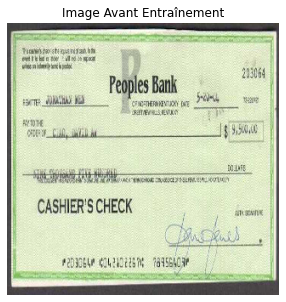

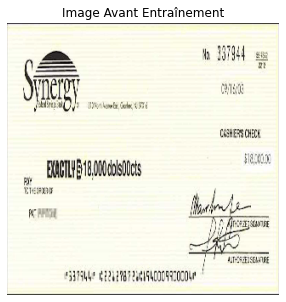

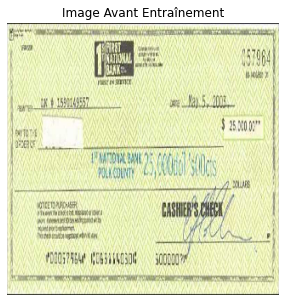

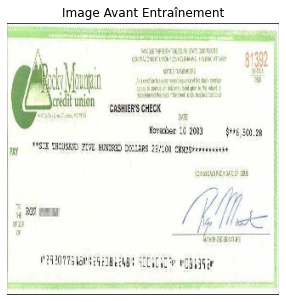

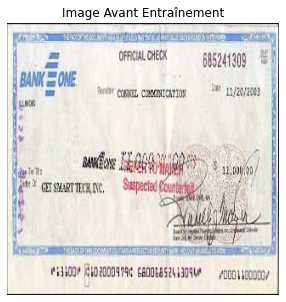

In [15]:
# Visualisation des images avant l'entraînement en couleur d'origine
for i in range(5):  # Afficher les premières 5 images
    plt.figure(figsize=(5, 5))
    plt.imshow(images_color[i].astype('uint8'))  # Afficher en couleur d'origine
    plt.title('Image Avant Entraînement')
    plt.axis('off')
    plt.show()

In [16]:
# Modèle de segmentation avec TensorFlow
def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)  # Définir la couche d'entrée du modèle
    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # Couche de convolution
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)  # Couche de pooling
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)  # Couche de convolution
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)  # Couche de pooling

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)  # Couche de convolution
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)  # Couche de pooling

    # Bottleneck
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)  # Couche de convolution

    # Decoder
    up1 = layers.UpSampling2D((2, 2))(conv4)  # Couche d'up-échantillonnage
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up1)  # Couche de convolution

    up2 = layers.UpSampling2D((2, 2))(conv5)  # Couche d'up-échantillonnage
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)  # Couche de convolution

    up3 = layers.UpSampling2D((2, 2))(conv6)  # Couche d'up-échantillonnage
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up3)  # Couche de convolution

    output = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv7)  # Couche de sortie

    return models.Model(inputs=inputs, outputs=output)  # Créer et retourner le modèle

In [17]:
# Créer le modèle
model = create_model(images[0].shape)  # Utiliser la forme de la première image comme entrée

In [18]:
# Résumé du modèle
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 320, 320, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 80, 80, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 80, 80, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 160, 160, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 160, 160, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 320, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 320, 320, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 320, 320, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,169 (2.96 MB)

 Trainable params: 775,169 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compiler le modèle

In [ ]:
# Entraîner le modèle
history = model.fit(images, masks, epochs=150, batch_size=16, validation_split=0.2)  # Entraîner le modèle

Epoch 1/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.8072 - loss: 0.3487

In [ ]:
# Affichage des courbes d'erreur
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Sauvegarde du modèle au format natif de Keras
model.save("segmentation_model.keras")

In [ ]:
# Chargement du modèle
loaded_model = models.load_model("segmentation_model.keras")

In [ ]:
# Segmenter les images normales
segmented_images = model.predict(images)  # Prédire les images segmentées

In [ ]:
# Visualisation des images segmentées avant les opérations morphologiques
for i in range(len(images)):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title('Image Normale')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)  # Ajout de la sous-trame pour afficher le masque
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title('Masque')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(segmented_images[i].squeeze(), cmap='gray')
    plt.title('Image Segmentée')
    plt.axis('off')

    plt.show()

In [ ]:
# Appliquer l'opération de Top Hat sur les images segmentées
segmented_images_tophat = np.array([top_hat(img) for img in segmented_images])

In [ ]:
# Appliquer un seuillage pour rendre les images binaires
segmented_images_tophat_binary = threshold_images(segmented_images_tophat)

In [ ]:
# Visualisation des images binaires après l'opération de Top Hat
for i in range(len(images)):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title('Image Normale')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(segmented_images[i].squeeze(), cmap='gray')
    plt.title('Image Segmentée')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(segmented_images_tophat[i].squeeze(), cmap='gray')
    plt.title('Top Hat sur Image Segmentée')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(segmented_images_tophat_binary[i].squeeze(), cmap='gray')
    plt.title('Image Segmentée Binaire')
    plt.axis('off')
    
     # Vérification si les images sont binaires
     #print("Image Segmentée (Binaire) :", check_binary_image(segmented_images[i]))
    print("Top Hat sur Image Segmentée (Binaire) :", check_binary_image(segmented_images_tophat_binary[i]))
    
    plt.show()